# Density Analysis Inside the Pore

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re,glob,os
from scipy import integrate
from numpy import pi as π
import dgutils
from pimcscripts import pimchelp
from collections import defaultdict
from scipy import interpolate

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Notebook display options
%config InlineBackend.figure_format = 'svg'

# plot style
plot_style = {'aps':'../include/aps.mplstyle', 'notebook':'../include/notebook.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['notebook'])

figsize = plt.rcParams['figure.figsize']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# local helper utilities
import hg_utils
from hg_utils import lab

### Some definitions related to the location of data files

In [2]:
ΔR = [2.0,3.0,4.0]
L = 100.0
R = 12.0
T = 2.0

## Load the position density file from a compressed .npy

### We also extract the header/discretization from the file

In [3]:
ρ = {}
num_grid_sep = {}
δ = {}

for cΔR in ΔR:
    ρ_data = np.load(f'{hg_utils.base_dir(cΔR,cylinder=False)}/gce-position-{lab(cΔR)}.npz')
    ρ[lab(cΔR)] = ρ_data['ρ']
    δ[lab(cΔR)] = ρ_data['δ']
    num_grid_sep[lab(cΔR)] = int(ρ_data['num_grid_sep'])

### Load the qmc-measured 1D Density from disk

In [4]:
reduce_params = {'reduce':'T', 'L':100, 'μ':-7.2}

ρ_1d_qmc = {}
for cΔR in ΔR:
    ρ_1d_qmc[lab(cΔR)] = pimchelp.PIMCResults(pimchelp.get_reduce_name(**reduce_params, base_dir=hg_utils.base_dir(cΔR),
                                                                       estimator='linedensity'))
    
    reduce_par = ρ_1d_qmc[lab(cΔR)].params[0]

## Plot a few slices

In [5]:
cΔR = 4.0
w = 3.0

δz = δ[lab(cΔR)][-1]
z = np.arange(-L/2,L/2,δz) + δz/2

mid_idx = int(num_grid_sep[lab(cΔR)]/2)

z_slices = [mid_idx-int(0.25*L/δz),mid_idx-int(2*w/δz),mid_idx-int(w/δz)]\
           + list(range(mid_idx-int(0.5*w/δz),mid_idx+int(0.5*w/δz)+1))\
           + [mid_idx+int(w/δz),mid_idx+int(2*w/δz),mid_idx+int(0.25*L/δz)]

z_slices = [mid_idx-int(0.25*L/δz),mid_idx-int(2*w/δz),mid_idx-int(w/δz)]\
           + list(range(mid_idx-int(1*w/δz)+1,mid_idx+int(1*w/δz)))\
           + [mid_idx+int(w/δz),mid_idx+int(2*w/δz),mid_idx+int(0.25*L/δz)]
num_z_slices = len(z_slices)

# create a list of slices using |z|
mod_z_slices = []
for i,cz in enumerate(z_slices[:int(num_z_slices/2)]):
    mod_z_slices += [z_slices[i],z_slices[-1-i]]

mod_z_slices += [z_slices[i+1]]
mod_z_slices = mod_z_slices[::-1]

# break this up into two arrays, useful for plotting
z_pos_slices = z_slices[int(num_z_slices/2)+1:]
z_neg_slices = z_slices[:int(num_z_slices/2)][::-1]

In [6]:
def plot_radial_density_row(_ax,_z_slices): 
    
    #_ax = _fig.subplots(nrows=1,ncols=len(_z_slices), sharex=True, sharey=True)    

    for i,cz in enumerate(_z_slices):
        _ax[i].imshow(ρ[lab(cΔR)][:,:,cz],extent=[-R,R,-R,R], cmap='Spectral_r',
                      vmin=0, vmax=np.max(ρ[lab(cΔR)][:,:,0]))
        _ax[i].set_xlabel(r'$z \;(\rm \AA)$')
        _ax[i].text(1.0,0.0,f'$x = {z[cz]:.1f}\;$'+r'${\rm \AA}$',ha='right',va='bottom',color='w',
                   transform=_ax[i].transAxes, fontsize=6)
                        
    _ax[0].set_ylabel(r'$y \;(\rm \AA)$');
    return _ax

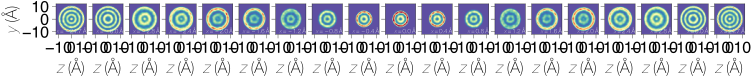

In [7]:
plt.style.reload_library()
with plt.style.context(plot_style['notebook']):
    
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=1,ncols=len(z_slices),sharex=True,sharey=True, figsize=(12,4))
    plot_radial_density_row(ax,z_slices)

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


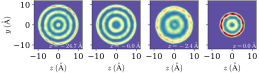

In [8]:
plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(figsize[0],0.5*figsize[0]),sharex=True,
                          sharey=True,constrained_layout=False)
    plot_radial_density_row(ax,[z_slices[0],z_slices[1],z_slices[3],mid_idx])
    
    plt.savefig(f'../figures/z_slices_{lab(cΔR)}.pdf')

## Examine the central slice at higher resolution

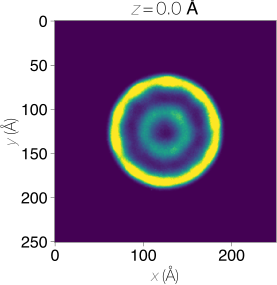

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True, figsize=(4,4))
ax.imshow(ρ[lab(cΔR)][:,:,mid_idx], vmin=0, vmax=0.1)
ax.set_title(f'$z = {mid_idx*δz-L/2 + δz/2:.1f}$ Å')
ax.set_xlabel(r'$x \;(\rm \AA)$')
ax.set_ylabel(r'$y \;(\rm \AA)$');

### Slice through the middle

In [10]:
def plot_pore_cut(_ax, x_cut):  
    
    im = _ax.imshow(ρ[lab(cΔR)][:,x_cut,:], extent=[-L/2,L/2,-R,R], cmap='Spectral_r', vmax=0.17)
    _ax.set_xlabel(r'$x\; (\rm \AA)$')
    _ax.set_ylabel(r'$y\; (\rm \AA)$')
    #_ax.set_title(r'$x = 0.0\; (\rm \AA)$')
    return _ax,im


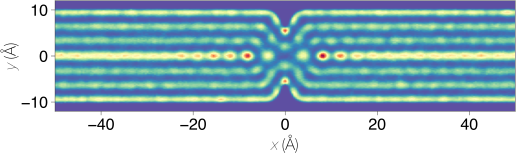

In [11]:
plt.style.reload_library()
with plt.style.context(plot_style['notebook']):
    fig,ax = plt.subplots(figsize=(8,4))
    plot_pore_cut(ax,mid_idx)

(0.0, 0.1)

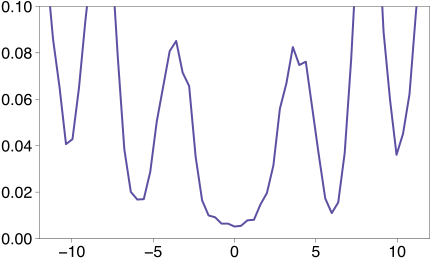

In [12]:
plt.plot(z,ρ[lab(cΔR)][mid_idx,mid_idx,:])
plt.xlim(-12,12)
plt.ylim(0,0.1)

## Make a combined figure showing cut and slices

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


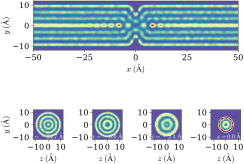

In [13]:
plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    
    figsize = plt.rcParams['figure.figsize']
    fig = plt.figure(figsize=(figsize[0],1.2*figsize[1]), constrained_layout=True)
    cut_fig,slice_fig = fig.subfigures(nrows=2,ncols=1, height_ratios=[1,1])
    
    ax_cut = cut_fig.subplots(1,1)
    plot_pore_cut(ax_cut,mid_idx)
    
    ax_slice = slice_fig.subplots(1,4)
    plot_radial_density_row(ax_slice,[z_slices[0],z_slices[1],z_slices[3],mid_idx])
    
    plt.savefig('../figures/pore_adsorption_details.pdf')

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


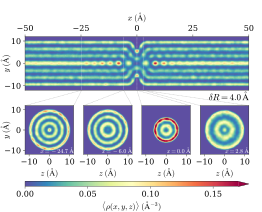

In [15]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import axes_size
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    
    figsize = plt.rcParams['figure.figsize']
    fig = plt.figure(figsize=(figsize[0],1.21*figsize[1]), constrained_layout=False)
    main_fig,cb_fig = fig.subfigures(nrows=2,ncols=1, height_ratios=[30,1])
    gs = gridspec.GridSpec(2, 4, figure=main_fig, hspace=-0.3)
    
    # Add the cut at x=0
    ax_cut = fig.add_subplot(gs[0, :])    
    ax_cut,im = plot_pore_cut(ax_cut,mid_idx)    
    ax_cut.xaxis.set_label_position('top') 
    ax_cut.xaxis.tick_top()
    ax_cut.xaxis.set_label_coords(0.5,1.30)
    ax_cut.yaxis.set_label_coords(-0.065,0.5)

    # add vertical lines indicating positions of slices
    active_slices = [z_slices[0],z_slices[1],mid_idx,z_slices[-3]]
    for i,cz_slice in enumerate(active_slices):
        ax_cut.axvline(x=z[cz_slice],lw=0.5,color='w',ls=':', alpha=0.5)
        
    # add a label for the current value of ΔR
    ax_cut.text(1.0,-0.22,f'$\delta R = {cΔR:.1f}\,$'+r'${\rm \AA}$', 
                transform=ax_cut.transAxes, ha='right', va='bottom') 

    # Now we plot the z-slices
    ax_slice = [fig.add_subplot(gs[1,0])]
    for i in range(1,len(active_slices)):
        ax_slice.append(fig.add_subplot(gs[1,i],sharex=ax_slice[0]))
        ax_slice[i].set_yticks([])
    
    ax_slice[0].yaxis.set_label_coords(-0.3,0.5)
    
    plot_radial_density_row(ax_slice,active_slices)
    
    # Plot the call-out lines
    for i,cz_slice in enumerate(active_slices):
        # ax_slice[i].annotate("",
        #         xy=(0, R), xycoords='data',zorder=-100,
        #         xytext=(z[cz_slice], -R), textcoords=ax_cut.transData,
        #         arrowprops=dict(arrowstyle="-", shrinkA=0,shrinkB=0,
        #                     connectionstyle="arc3", color='gray', ls=':', alpha=0.5,lw=0.5))
        ax_slice[i].annotate("",
                xy=(-R, R), xycoords='data',zorder=-100,
                xytext=(z[cz_slice], -R), textcoords=ax_cut.transData,
                arrowprops=dict(arrowstyle="-", shrinkA=0,shrinkB=0,
                            connectionstyle="arc3", color='gray', ls=':', alpha=0.5,lw=0.5))
        ax_slice[i].annotate("",
                xy=(R, R), xycoords='data',zorder=-100,
                xytext=(z[cz_slice], -R), textcoords=ax_cut.transData,
                arrowprops=dict(arrowstyle="-", shrinkA=0,shrinkB=0,
                            connectionstyle="arc3", color='gray', ls=':', alpha=0.5,lw=0.5))

    # Colorbar
    cb_ax = cb_fig.subplots(1,1)    
    cb = cb_fig.colorbar(im, cax=cb_ax, orientation='horizontal',extend='max', location='bottom')
    cb.set_label(r'$\langle \rho(x,y,z) \rangle \;(\rm \AA^{-3})$',labelpad=3)
    
    plt.savefig(f'../figures/pore_adsorption_details_{lab(cΔR)}.pdf')
    plt.savefig(f'../figures/pore_adsorption_details_{lab(cΔR)}.svg')

## Integrate along the pore

In [16]:
ρxy = (np.sum(ρ[lab(cΔR)],axis=2)*δz)

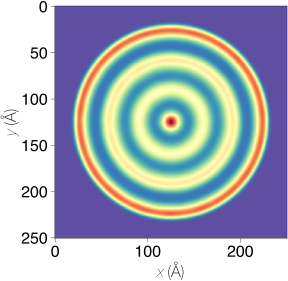

In [17]:
fig,ax = plt.subplots()
ax.imshow(ρxy, cmap='Spectral_r')
ax.set_xlabel(r'$x \;(\rm \AA)$')
ax.set_ylabel(r'$y \;(\rm \AA)$');

### Check we have the correct number of particles

In [18]:
N = {}
for cΔR in ΔR:
    N[lab(cΔR)] = np.sum(ρ[lab(cΔR)])*np.prod(δ[lab(cΔR)])
    
print(N)

{'dR_eq_2.0': np.float64(948.7643713971959), 'dR_eq_3.0': np.float64(950.0534659100906), 'dR_eq_4.0': np.float64(942.4340318022657)}


## Compute the radial density at each z-slice

In [19]:
%%time
ρ_rad = {}

for cΔR in ΔR:

    dR = 2*np.sqrt(δ[lab(cΔR)][0]**2 + δ[lab(cΔR)][1]**2)
    N_R = int(np.floor(R/dR))+1

    norm = np.ones(N_R)
    rvals = np.arange(0,R,dR)

    for n in range(N_R):
        norm[n] /= np.pi*(2*n+1)*dR*dR
 
    _ρ_rad = np.zeros([num_grid_sep[lab(cΔR)],N_R])
    
    for iz in range(num_grid_sep[lab(cΔR)]):
        for i in range(num_grid_sep[lab(cΔR)]):
            y = -R + δ[lab(cΔR)][1]*i + δ[lab(cΔR)][1]/2
            for j in range(num_grid_sep[lab(cΔR)]):
                x = -R + δ[lab(cΔR)][0]*j + δ[lab(cΔR)][0]/2
                _r = np.sqrt(x**2 + y**2)
                k = int(_r/dR)

                if k < N_R:                
                    _ρ_rad[iz,k] += ρ[lab(cΔR)][i,j,iz]*δ[lab(cΔR)][0]*δ[lab(cΔR)][1]
                    
    ρ_rad[lab(cΔR)] = _ρ_rad*norm

CPU times: user 1min 30s, sys: 55.5 ms, total: 1min 30s
Wall time: 1min 30s


## Average over +/- z-values and compute an error bar

In [20]:
ave_ρ_rad = {}
err_ρ_rad = {}

for cΔR in ΔR:
    num_pos_z = int(num_grid_sep[lab(cΔR)]/2)+1
    ave_ρ_rad[lab(cΔR)] = np.zeros([num_pos_z,N_R])
    err_ρ_rad[lab(cΔR)] = np.zeros_like(ave_ρ_rad[lab(cΔR)])
    
    ave_ρ_rad[lab(cΔR)][0,:] = ρ_rad[lab(cΔR)][mid_idx,:]
    
    for iz in range(1,num_pos_z):
        combo_ρ = np.hstack((ρ_rad[lab(cΔR)][mid_idx-iz][:,np.newaxis],ρ_rad[lab(cΔR)][mid_idx+iz][:,np.newaxis]))
        ave_ρ_rad[lab(cΔR)][iz,:] = np.average(combo_ρ,axis=1)
        err_ρ_rad[lab(cΔR)][iz,:] = np.std(combo_ρ,axis=1)      

In [21]:
def plot_radial_density(ax,_color,cΔR,cz, ls='-', label='_nolegend_'):
    r_interp = np.linspace(0,rvals[-1],1000)
    _ρ_rad = ρ_rad[lab(cΔR)][cz]
    interp_ρ_rad = interpolate.interp1d(rvals, _ρ_rad, kind='slinear')
    ax.plot(r_interp,interp_ρ_rad(r_interp),ls=ls,color=_color, lw=0.5)
    ax.plot(rvals,_ρ_rad,'o',label=label, color=_color)
    
def plot_ave_radial_density(ax,_color,cΔR,cz, ls='-', label='_nolegend_'):
    r_interp = np.linspace(0,rvals[-1],1000)
    _ρ_rad = ave_ρ_rad[lab(cΔR)][cz]
    interp_ρ_rad = interpolate.interp1d(rvals, _ρ_rad, kind='slinear')
    
    ax.plot(r_interp,interp_ρ_rad(r_interp),ls=ls,color=_color, lw=0.5)
    ax.errorbar(rvals,_ρ_rad,yerr=err_ρ_rad[lab(cΔR)][cz],marker='o',
                label=label, color=_color, ls='None', elinewidth=0.5)


### Plot the Raw +/- z data

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


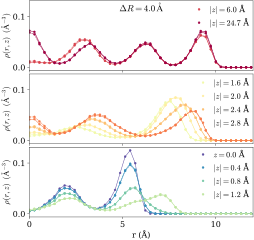

In [22]:
ρ_colors = dgutils.colors.get_linear_colors('Spectral_r',len(z_pos_slices)+1)

cΔR = 4.0

plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[0]))
    plt.subplots_adjust(hspace=0.05)
    plot_radial_density(ax[-1],ρ_colors[0],cΔR,mid_idx,label=f'$z = {z[mid_idx]:.1f}$ Å')
    #axs = [ax[-1],ax[-1],ax[-1],ax[1],ax[0],ax[0]]
    axs = [ax[-1],ax[-1],ax[-1],ax[1],ax[1],ax[1],ax[1],ax[0],ax[0]]
    
    for i in range(len(z_pos_slices)):
        plot_radial_density(axs[i],ρ_colors[i+1],cΔR,z_pos_slices[i], label=f'$|z| = {z[z_pos_slices[i]]:.1f}$ Å')
        plot_radial_density(axs[i],ρ_colors[i+1],cΔR,z_neg_slices[i],ls='--')

    ax[-1].set_xlim(0,R)
    ax[-1].set_xlabel('r (Å)')
    
    ax[0].text(0.5,0.95,f'$\Delta R = {cΔR:.1f}\,$'+r'$\rm \AA$',ha='center', va='top',
              transform=ax[0].transAxes)

    for cax in ax:
        cax.legend(loc='upper right',borderpad=0)
        cax.set_ylabel(r'$\rho(r,z)\;\; (\rm \AA^{-3})$')

    plt.savefig(f'../figures/rho_zr_dR_eq_{cΔR:3.1f}.pdf')
#plt.axvline(x=1.75, color='grey', ls=':')


### Plot the +/- z averaged data with errorbars

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


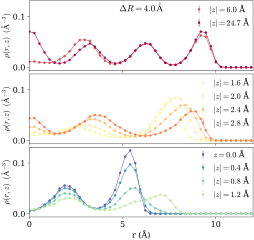

In [23]:
ρ_colors = dgutils.colors.get_linear_colors('Spectral_r',len(z_pos_slices)+1)

cΔR = 4.0

plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[0]))
    plt.subplots_adjust(hspace=0.05)
    
    plot_ave_radial_density(ax[-1],ρ_colors[0],cΔR,0,label=f'$z = {z[mid_idx]:.1f}$ Å')
    axs = [ax[-1],ax[-1],ax[-1],ax[1],ax[1],ax[1],ax[1],ax[0],ax[0]]

    for i in range(len(z_pos_slices)):
        plot_ave_radial_density(axs[i],ρ_colors[i+1],cΔR,z_pos_slices[i]-mid_idx, label=f'$|z| = {z[z_pos_slices[i]]:.1f}$ Å')

    ax[-1].set_xlim(0,R)
    ax[-1].set_xlabel('r (Å)')
    
    ax[0].text(0.5,0.95,f'$\Delta R = {cΔR:.1f}\,$'+r'$\rm \AA$',ha='center', va='top',
              transform=ax[0].transAxes)

    for cax in ax:
        cax.legend(loc='upper right',borderpad=0)
        cax.set_ylabel(r'$\rho(r,z)\;\; (\rm \AA^{-3})$')

    plt.savefig(f'../figures/ave_rho_zr_dR_eq_{cΔR:3.1f}.pdf')
#plt.axvline(x=1.75, color='grey', ls=':')


### 3D Perspective Plot of the Radial Densities

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


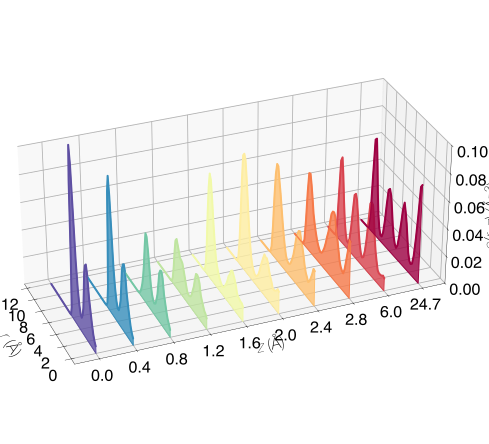

In [24]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

ρ3d_colors = dgutils.colors.get_linear_colors('Spectral_r',len(z_pos_slices)+1)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, -22)

labels = [0.0]
_ρ_rad = ρ_rad[lab(cΔR)][mid_idx][::-1]
_loc = -np.ones_like(rvals)
_rvals = rvals[::-1]
ax.plot(_rvals,-1*np.ones_like(rvals),_ρ_rad, color=ρ3d_colors[0])
verts = [(_rvals[j],_loc[j],_ρ_rad[j]) for j in range(len(rvals))] + [(rvals.min(),-1,0),(rvals.max(),-1,0)]
ax.add_collection3d(Poly3DCollection([verts],color=ρ3d_colors[0], alpha=0.8)) 

for i,cz in enumerate(z_pos_slices):
    _ρ_rad = ρ_rad[lab(cΔR)][cz][::-1]
    _loc = i*np.ones_like(rvals)
    _rvals = rvals[::-1]
    ax.plot(_rvals,_loc,_ρ_rad, color=ρ3d_colors[i+1])
    labels.append(f'{z[cz]:.1f}')
    
    #verts = [(_rvals[i],_loc[i],_ρ_rad[i]) for i in range(len(rvals))] + [(rvals.max(),i,0),(rvals.min(),i,0)]
    verts = [(_rvals[j],_loc[j],_ρ_rad[j]) for j in range(len(rvals))] + [(rvals.min(),i,0),(rvals.max(),i,0)]

    ax.add_collection3d(Poly3DCollection([verts],color=ρ3d_colors[i+1], alpha=0.8)) 
    
ax.set_box_aspect((1, 2.5, 1))  # aspect ratio is 1:1:1 in data space

ax.invert_xaxis()
ax.set_zlim(0,0.1)
ax.set_yticks(range(-1,len(z_pos_slices)))
ax.set_yticklabels(labels)

ax.set_zlabel(r'$\rho(r,z)\; (\rm \AA^{-3})$')
ax.set_xlabel(r'$r\; (\rm \AA)$');
ax.set_ylabel(r'$z\; (\rm \AA)$');

plt.savefig('../figures/3d_rho_r_z.pdf')

## Compute the effective 1D Density

In [25]:
from scipy.signal import argrelmin,argrelmax

#First we determine the cutoff radius for the central core
rcut = {}
rcut_idx = {}

for cΔR in ΔR:
    rcut[lab(cΔR)] = np.zeros([num_grid_sep[lab(cΔR)]])
    rcut_idx[lab(cΔR)] = np.zeros([num_grid_sep[lab(cΔR)]],dtype=int)
    for iz in range(num_grid_sep[lab(cΔR)]):
        idx_min = argrelmin(ρ_rad[lab(cΔR)][iz,:])[0][0]
        
        #idx_min = np.where(rvals > 1.75)[0][0]
        
        # this criteria is determined by viewing the radial density plots
        if rvals[idx_min] < 2.3:
            rcut[lab(cΔR)][iz] = rvals[idx_min]
            rcut_idx[lab(cΔR)][iz] = idx_min
    
ρ_1d = {}
ρₒ = {}
for cΔR in ΔR:
    ρ_1d[lab(cΔR)] = np.zeros(num_grid_sep[lab(cΔR)])

    for iz in range(num_grid_sep[lab(cΔR)]):
        r_idx = rcut_idx[lab(cΔR)][iz]
        #ρ_1d[lab(cΔR)][iz] = integrate.simps(rvals[:r_idx+1]*ρ_rad[lab(cΔR)][iz,:r_idx+1],rvals[:r_idx+1])*2*π
        ρ_1d[lab(cΔR)][iz] = np.sum(rvals[:r_idx+1]*ρ_rad[lab(cΔR)][iz,:r_idx+1])*2*π*dR


    # now integrate along z to get the total average density in the core
    #ρₒ[lab(cΔR)] = integrate.simps(ρ_1d[lab(cΔR)],z)/L
    ρₒ[lab(cΔR)] = np.sum(ρ_1d[lab(cΔR)])*δz/L

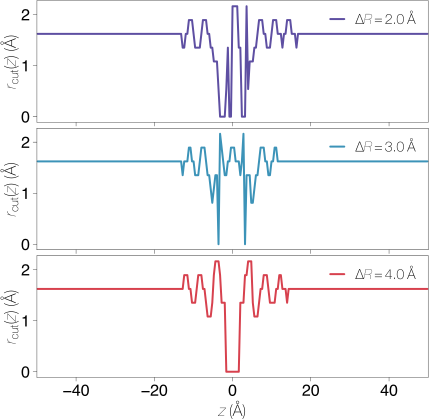

In [26]:
plt.style.reload_library()
with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[0]))
    plt.subplots_adjust(hspace=0.05)
    
    col = [colors[0],colors[1],colors[-2]]
    for i,cΔR in enumerate(ΔR):
        label =f'$\Delta R = {cΔR:.1f}\;$'+r'${\rm \AA}$'
        ax[i].plot(z,rcut[lab(cΔR)],'-',color=col[i], label=label)
        ax[i].legend()
        ax[i].set_xlim(-50,50)
        ax[i].set_ylabel(r'$r_{\rm cut}(z)\; (\rm \AA)$');

ax[-1].set_xlabel(r'$z\; (\rm \AA)$');

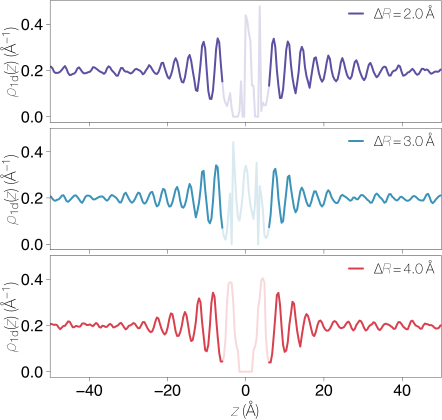

In [27]:
z_mask_in = np.where(np.abs(z)<=2*w)
plt.style.reload_library()
with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[0]))
    plt.subplots_adjust(hspace=0.05)
    
    col = [colors[0],colors[1],colors[-2]]
    
    for i,cΔR in enumerate(ΔR):
        label =f'$\Delta R = {cΔR:.1f}\;$'+r'${\rm \AA}$'
        
        # central portion 
        ax[i].plot(z[z_mask_in], ρ_1d[lab(cΔR)][z_mask_in],'-',color=col[i], alpha=0.2)
        
        # z < -z_cut
        ax[i].plot(z[:z_mask_in[0][0]+1], ρ_1d[lab(cΔR)][:z_mask_in[0][0]+1],'-',color=col[i])
        # z > -z_cut
        ax[i].plot(z[z_mask_in[0][-1]:], ρ_1d[lab(cΔR)][z_mask_in[0][-1]:],'-',color=col[i], label=label)
        
        #_x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par)
        #ax[i].errorbar(_x-L/2,_ρ,yerr=_Δρ, color=col[i], marker='o', ls='None', alpha=0.5, label='QMC')  

        ax[i].legend(loc='upper right', borderpad=0)
        ax[i].set_xlim(-50,50)
        ax[i].set_ylabel(r'$\rho_{\rm 1d}(z)\; (\rm \AA^{-1})$');


ax[-1].set_xlabel(r'$z\; (\rm \AA)$');
#ax[-1].plot(z,np.average(ρ_1d[lab(cΔR)])+0.1*np.sin(kz[np.argmax(ρ̂[lab(cΔR)].real)]*z-0.3),'--',lw=1)

## Compare against the direct QMC measured value (subtracting the average)

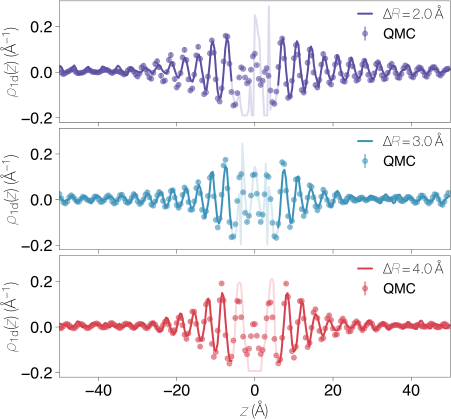

In [28]:
z_mask_in = np.where(np.abs(z)<=2*w)
plt.style.reload_library()
with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[0]))
    plt.subplots_adjust(hspace=0.05)
    
    col = [colors[0],colors[1],colors[-2]]
    
    for i,cΔR in enumerate(ΔR):
        label =f'$\Delta R = {cΔR:.1f}\;$'+r'${\rm \AA}$'
        
        δρ_1d = ρ_1d[lab(cΔR)] - np.average(ρ_1d[lab(cΔR)])
        
        # central portion 
        ax[i].plot(z[z_mask_in], δρ_1d[z_mask_in],'-',color=col[i], alpha=0.2)
        
        # z < -z_cut
        ax[i].plot(z[:z_mask_in[0][0]+1], δρ_1d[:z_mask_in[0][0]+1],'-',color=col[i])
        # z > -z_cut
        ax[i].plot(z[z_mask_in[0][-1]:], δρ_1d[z_mask_in[0][-1]:],'-',color=col[i], label=label)
        
        _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par)
        ax[i].errorbar(_x-L/2,_ρ-np.average(_ρ),yerr=_Δρ, color=col[i], marker='o', ls='None', alpha=0.5, label='QMC')     

        ax[i].legend(loc='upper right', borderpad=0)
        ax[i].set_xlim(-50,50)
        ax[i].set_ylabel(r'$\rho_{\rm 1d}(z)\; (\rm \AA^{-1})$');
        
ax[-1].set_xlabel(r'$z\; (\rm \AA)$');

## Investigate 2k_F component via Fourier Transform

In [29]:
Δz = z[1]-z[0]
num_z = len(z)

ρ̂,ρ̂_qmc = {},{}
k = 2*π*np.fft.rfftfreq(num_z,Δz)
kF = {}
ρₒ_qmc = {}
for cΔR in ΔR:
    kF[lab(cΔR)] = π*ρₒ[lab(cΔR)]
    ρ̂[lab(cΔR)] = np.cos(0.5*L*k)*np.fft.rfft(ρ_1d[lab(cΔR)]-np.average(ρ_1d[lab(cΔR)]))*Δz

    _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par)
    k_qmc = 2*π*np.fft.rfftfreq(len(_x),_x[1]-_x[0])
    ρ̂_qmc[lab(cΔR)] = np.cos(0.5*L*k_qmc)*np.fft.rfft(_ρ-np.average(_ρ))*(_x[1]-_x[0])
    
    ρₒ_qmc[lab(cΔR)] = np.sum(_ρ)*(_x[1]-_x[0])/L 


In [30]:
ρₒ_qmc,ρₒ

({'dR_eq_2.0': np.float64(0.2443082663685),
  'dR_eq_3.0': np.float64(0.247348034972),
  'dR_eq_4.0': np.float64(0.244427137551)},
 {'dR_eq_2.0': np.float64(0.18937104468290644),
  'dR_eq_3.0': np.float64(0.19533349327838978),
  'dR_eq_4.0': np.float64(0.19257235334008613)})

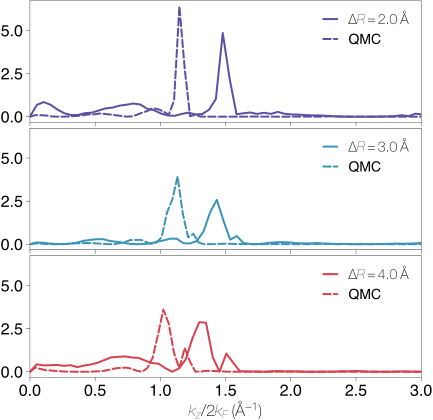

In [31]:
plt.style.reload_library()
with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[0]))
    plt.subplots_adjust(hspace=0.05)
    
    col = [colors[0],colors[1],colors[-2]]
    for i,cΔR in enumerate(ΔR):
        label =f'$\Delta R = {cΔR:.1f}\;$'+r'${\rm \AA}$'
        ax[i].plot(k/(2*kF[lab(cΔR)]),np.abs(ρ̂[lab(cΔR)])**2,'-',color=col[i], label=label)
        
        ax[i].plot(k_qmc/(2*π*ρₒ_qmc[lab(cΔR)]),np.abs(ρ̂_qmc[lab(cΔR)])**2,'--',color=col[i], label='QMC')    
        
        #ax[i].plot(kz,ρ̂[lab(cΔR)].imag,':',color=col[i])

        ax[i].legend()
        ax[i].set_xlim(0,3)
        #ax[i].set_ylabel(r'$r_{\rm cut}(z)\; (\rm \AA)$');

ax[-1].set_xlabel(r'$k_z/2k_F\; (\rm \AA^{-1})$');